In [2]:
pip install pyinstaller

  Using cached pyinstaller-5.3-py3-none-macosx_10_13_universal2.whl (829 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.7/244.7 kB 2.2 MB/s eta 0:00:00a 0:00:01
  Using cached altgraph-0.17.2-py2.py3-none-any.whl (21 kB)
  Using cached macholib-1.16-py2.py3-none-any.whl (37 kB)
Note: you may need to restart the kernel to use updated packages.


In [11]:
#C2 1m

import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
from keras.models import load_model


ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelC2//1//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition//ModelC2//1//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelC2//1//model_corr.h5')

# 'C://Users//izhang//Desktop///ModelPrediction//ModelC2//1//ensemble_C2_1_corr_{i}.h5'
# 'C://Users//izhang//Desktop//ModelPrediction//ModelC2//1//modelC2_1_corr.h5'

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


import io
import datetime

sheet='C2'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))
# # df=df.drop(['D&J_Close30d_Avg.','D&J_Close30d_Min','Monthly Real GDP Index','TCV','FEDFUNDS','Unemployement Rate','SPX_Price30d_Std.','D&J_Close30d_Std.','VIX_Close30d_Max.','VIX_Close30d_Avg.','VIX_Close30d_Std.','VIX_Close30d_Min.'],axis=1)


values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # encoder = LabelEncoder()
# # # # print(values[:,0]) #PortQyt Value
# # values[:,0]=encoder.fit_transform(values[:,0])
# # print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
# print(reframed.shape)


# print(reframed.tail())

# split into train and test sets
values = reframed.values
n_train_months = 35
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = ((n_months+1))* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+5):-n_features*(1+5)+1]
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+5):-n_features*(1+5)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1) , n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# prediction interval for mlps on the housing regression dataset
from numpy import asarray
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import math
import numpy as np


# define and fit the model
def fit_model(X_train, y_train):
    features = X_train.shape[1]
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, verbose=0, epochs=50, batch_size=16)
    return model



# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
    ensemble = list()
    for i in range(n_members):
        model = fit_model(X_train, y_train) # define and fit the model on the training set
        yhat = model.predict(X_test, verbose=0) # evaluate model on the test set
        print(y_test.shape,yhat.shape)
        mae = mean_absolute_error(y_test, yhat)
        print('>%d, MAE: %.3f' % (i+1, mae))
        ensemble.append(model) # store the model
    return ensemble, model

# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X,n_members):
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = asarray(yhat)
    yhat = np.reshape(yhat,[n_members,1])
    print(yhat.shape)
    # yhat = scaled2.inverse_transform(yhat)
    yhat = scaler2.inverse_transform(yhat) # invert scaling for actual
    yhat = yhat[:,0]
    interval = 1.96 * yhat.std()/math.sqrt(len(yhat))
    lower, upper = yhat.mean() - interval, yhat.mean() + interval
    return lower, yhat.mean(), upper

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome1= pd.DataFrame(outcome)
outcome1




18
(37, 108)
(2, 108)
(35, 6, 18) (35, 1) (2, 6, 18) (2, 1)


2022-09-04 22:39:38.638901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:39:38.699970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:39:39.274921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:39:39.331997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:39:39.662025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:39:39.718536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:39:40.015941: I tensorflow/core/grappler/optimizers/cust

(25, 1)
95% prediction interval: [635.6, 646.6]
True value: 0.5


2022-09-04 22:39:48.433510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:39:48.493075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Prediction,95%CI.Min,95%CI.Max
0,641.096558,635.633138,646.559977


# C2-2m

In [3]:
#C2 2m

import os
from keras.models import load_model


ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelC2//2//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition/ModelC2//2//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelC2//2//model_corr.h5')


from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import io
import datetime

sheet='C2'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))


values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
# print(reframed.shape)


# print(reframed.tail())


# split into train and test sets
values = reframed.values
n_train_months = 36
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = ((n_months+1))* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+4):-n_features*(1+4)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+4):-n_features*(1+4)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1) , n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# prediction interval for mlps on the housing regression dataset
from numpy import asarray
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import math
import numpy as np

 
# define and fit the model
def fit_model(X_train, y_train):
    features = X_train.shape[1]
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, verbose=0, epochs=50, batch_size=16)
    return model

	
 
# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
    ensemble = list()
    for i in range(n_members):
        model = fit_model(X_train, y_train) # define and fit the model on the training set
        yhat = model.predict(X_test, verbose=0) # evaluate model on the test set
        print(y_test.shape,yhat.shape)
        mae = mean_absolute_error(y_test, yhat)
        print('>%d, MAE: %.3f' % (i+1, mae))
        ensemble.append(model) # store the model
    return ensemble
    
# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X,n_members):
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = asarray(yhat)
    yhat = np.reshape(yhat,[n_members,1])
    print(yhat.shape)
    # yhat = scaled2.inverse_transform(yhat)
    yhat = scaler2.inverse_transform(yhat) # invert scaling for actual
    yhat = yhat[:,0] 
    interval = 1.96 * yhat.std()/math.sqrt(len(yhat))
    lower, upper = yhat.mean() - interval, yhat.mean() + interval
    return lower, yhat.mean(), upper

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome2= pd.DataFrame(outcome)
outcome2


18
(37, 108)
(1, 108)
(36, 6, 18) (36, 1) (1, 6, 18) (1, 1)


2022-09-04 18:09:35.459262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 18:09:35.522424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 18:09:35.817303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 18:09:35.875607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 18:09:36.157335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 18:09:36.241919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 18:09:36.533776: I tensorflow/core/grappler/optimizers/cust

(25, 1)
95% prediction interval: [647.6, 659.1]
True value: 0.7


2022-09-04 18:09:44.042497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 18:09:44.104644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Prediction,95%CI.Min,95%CI.Max
0,653.343201,647.620582,659.06582


## C2_3M

In [4]:
# -*- coding: utf-8 -*-
"""C2_3m_Corr_Prediction.ipynb

"""

#load ensemble
# import os
# from keras.models import load_model

import os
from keras.models import load_model


ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelC2//3//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition/ModelC2//3//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelC2//3//model_corr.h5')

# from math import sqrt
# from numpy import concatenate
# from matplotlib import pyplot
# import pandas as pd
# from pandas import read_csv
# from pandas import DataFrame
# from pandas import concat
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import mean_squared_error
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM


sheet='C2'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))


values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)


# split into train and test sets
values = reframed.values
n_train_months = 36
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = (n_months+1)* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+3):-n_features*(1+3)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+3):-n_features*(1+3)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# prediction interval for mlps on the housing regression dataset
from numpy import asarray
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import math
import numpy as np

 
# define and fit the model
def fit_model(X_train, y_train):
    features = X_train.shape[1]
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, verbose=0, epochs=50, batch_size=16)
    return model

	
 
# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
    ensemble = list()
    for i in range(n_members):
        model = fit_model(X_train, y_train) # define and fit the model on the training set
        yhat = model.predict(X_test, verbose=0) # evaluate model on the test set
        print(y_test.shape,yhat.shape)
        mae = mean_absolute_error(y_test, yhat)
        print('>%d, MAE: %.3f' % (i+1, mae))
        ensemble.append(model) # store the model
    return ensemble

    
# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X,n_members):
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = asarray(yhat)
    yhat = np.reshape(yhat,[n_members,1])
    print(yhat.shape)
    # yhat = scaled2.inverse_transform(yhat)
    yhat = scaler2.inverse_transform(yhat) # invert scaling for actual
    yhat = yhat[:,0] 
    interval = 1.96 * yhat.std()/math.sqrt(len(yhat))
    lower, upper = yhat.mean() - interval, yhat.mean() + interval
    return lower, yhat.mean(), upper

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome3= pd.DataFrame(outcome)
outcome3

18
(37, 108)
(1, 108)
(36, 6, 18) (36, 1) (1, 6, 18) (1, 1)


2022-09-04 21:28:10.280300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:28:10.346758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:28:10.850744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:28:10.906375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:28:11.197711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:28:11.254939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:28:11.548725: I tensorflow/core/grappler/optimizers/cust

(25, 1)
95% prediction interval: [661.1, 669.8]
True value: 0.8


2022-09-04 21:28:19.152708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:28:19.208207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Prediction,95%CI.Min,95%CI.Max
0,665.452881,661.094324,669.811438


## C2_4M

In [5]:
# -*- coding: utf-8 -*-
"""C2_4m_Corr_Prediction.ipynb


"""

# #load ensemble
# import os
# from keras.models import load_model


ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelC2//4//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition//ModelC2//4//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelC2//4//model_corr.h5')

# from math import sqrt
# from numpy import concatenate
# from matplotlib import pyplot
# import pandas as pd
# from pandas import read_csv
# from pandas import DataFrame
# from pandas import concat
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import mean_squared_error
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM

sheet='C2'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))

values=df.values
# #
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)

# split into train and test sets
values = reframed.values
n_train_months = 36
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = (n_months+1)* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+2):-n_features*(1+2)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+2):-n_features*(1+2)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# prediction interval for mlps on the housing regression dataset
from numpy import asarray
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import math
import numpy as np

 
# define and fit the model
def fit_model(X_train, y_train):
    features = X_train.shape[1]
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, verbose=0, epochs=50, batch_size=16)
    return model

	
 
# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
    ensemble = list()
    for i in range(n_members):
        model = fit_model(X_train, y_train) # define and fit the model on the training set
        yhat = model.predict(X_test, verbose=0) # evaluate model on the test set
        print(y_test.shape,yhat.shape)
        mae = mean_absolute_error(y_test, yhat)
        print('>%d, MAE: %.3f' % (i+1, mae))
        ensemble.append(model) # store the model
    return ensemble


    
# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X,n_members):
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = asarray(yhat)
    yhat = np.reshape(yhat,[n_members,1])
    print(yhat.shape)
    # yhat = scaled2.inverse_transform(yhat)
    yhat = scaler2.inverse_transform(yhat) # invert scaling for actual
    yhat = yhat[:,0] 
    interval = 1.96 * yhat.std()/math.sqrt(len(yhat))
    lower, upper = yhat.mean() - interval, yhat.mean() + interval
    return lower, yhat.mean(), upper

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome4= pd.DataFrame(outcome)
outcome4


18
(37, 108)
(1, 108)
(36, 6, 18) (36, 1) (1, 6, 18) (1, 1)


2022-09-04 21:32:46.886853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:32:46.951083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:32:47.284603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:32:47.341360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:32:47.631708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:32:47.690370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:32:47.977883: I tensorflow/core/grappler/optimizers/cust

(25, 1)
95% prediction interval: [706.3, 715.3]
True value: 0.9


2022-09-04 21:32:55.970699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:32:56.028540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Prediction,95%CI.Min,95%CI.Max
0,710.794739,706.257312,715.332165


## C2_5m

In [7]:
# -*- coding: utf-8 -*-
"""C2_5m_Corr_Prediction.ipynb


"""

#load ensemble
import os
from keras.models import load_model


ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelC2//5//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition//ModelC2//5//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelC2//5//model_corr.h5')

# from math import sqrt
# from numpy import concatenate
# from matplotlib import pyplot
# import pandas as pd
# from pandas import read_csv
# from pandas import DataFrame
# from pandas import concat
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import mean_squared_error
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM

sheet='C2'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))

values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)

m=6-5
# split into train and test sets
values = reframed.values
n_train_months = 36
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = (n_months+1)* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+m):-n_features*(1+m)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+m):-n_features*(1+m)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome5= pd.DataFrame(outcome)
outcome5

18
(37, 108)
(1, 108)
(36, 6, 18) (36, 1) (1, 6, 18) (1, 1)


2022-09-04 21:40:02.268297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:40:02.324376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:40:02.609370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:40:02.663304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:40:02.950146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:40:03.006122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:40:03.289304: I tensorflow/core/grappler/optimizers/cust

(25, 1)
95% prediction interval: [751.3, 766.0]
True value: 1.0


2022-09-04 21:40:10.670301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:40:10.726998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Prediction,95%CI.Min,95%CI.Max
0,758.674988,751.334276,766.015699


In [ ]:
## C2_6m

In [8]:
# -*- coding: utf-8 -*-
"""C2_6m_corr_Prediction.ipynb
"""

# #load ensemble
# import os
# from keras.models import load_model

# drive.mount('/content/drive')

ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelC2//6//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition//ModelC2//6//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelC2//6//model_corr.h5')

sheet='C2'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))


values=df.values

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)

m=6-6
# split into train and test sets
values = reframed.values
n_train_months = 36
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = (n_months+1)* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+m):-n_features*(1+m)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+m):-n_features*(1+m)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome6= pd.DataFrame(outcome)
outcome6

18
(37, 108)
(1, 108)
(36, 6, 18) (36, 1) (1, 6, 18) (1, 1)


2022-09-04 21:44:15.962729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:44:16.018595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:44:16.323657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:44:16.378861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:44:16.668654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:44:16.724507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:44:17.002453: I tensorflow/core/grappler/optimizers/cust

(25, 1)
95% prediction interval: [809.1, 820.6]
True value: 0.9


2022-09-04 21:44:24.635420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:44:24.691073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Prediction,95%CI.Min,95%CI.Max
0,814.84967,809.125346,820.573995


In [ ]:
## C2_12M

In [9]:
# -*- coding: utf-8 -*-
"""C2_12m_Prediction.ipynb
"""

#load ensemble
import os
from keras.models import load_model


ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelC2//12//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition//ModelC2//12//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelC2//12//model_corr.h5')

# from math import sqrt
# from numpy import concatenate
# from matplotlib import pyplot
# import pandas as pd
# from pandas import read_csv
# from pandas import DataFrame
# from pandas import concat
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import mean_squared_error
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM

sheet='C2'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

values=df.values
# #
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
# n_months = 11
n_months = 23
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)


m=6-6
# split into train and test sets
values = reframed.values
n_train_months = 17
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = ((n_months+1)//2)* n_features #the following 12
# n_obs = (n_months+1)* n_features #the following 
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+m):-n_features*(1+m)+1] 
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+m):-n_features*(1+m)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+m):-n_features*(1+m)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1)//2, n_features))
# train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1)//2, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome12= pd.DataFrame(outcome)
outcome12


(19, 432)
(2, 432)
(17, 12, 18) (17, 1) (2, 12, 18) (2, 1)


2022-09-04 21:51:44.465185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:51:44.522217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:51:45.343344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:51:45.399176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:51:45.719928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:51:45.776276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:51:46.104342: I tensorflow/core/grappler/optimizers/cust

(25, 1)
95% prediction interval: [763.4, 777.7]
True value: 1.0


2022-09-04 21:51:54.243416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 21:51:54.299814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Prediction,95%CI.Min,95%CI.Max
0,770.552551,763.446096,777.659007


In [ ]:
## C2 Predictions

     Asset Product Month Ahead  Prediction   95%CI.Min   95%CI.Max
0  Options      C2           1  642.158264  637.581375  646.735154
0  Options      C2           2  653.343201  647.620582  659.065820
0  Options      C2           3  665.452881  661.094324  669.811438
0  Options      C2           4  710.794739  706.257312  715.332165
0  Options      C2           5  758.674988  751.334276  766.015699
0  Options      C2           6  814.849670  809.125346  820.573995
0  Options      C2          12  770.552551  763.446096  777.659007


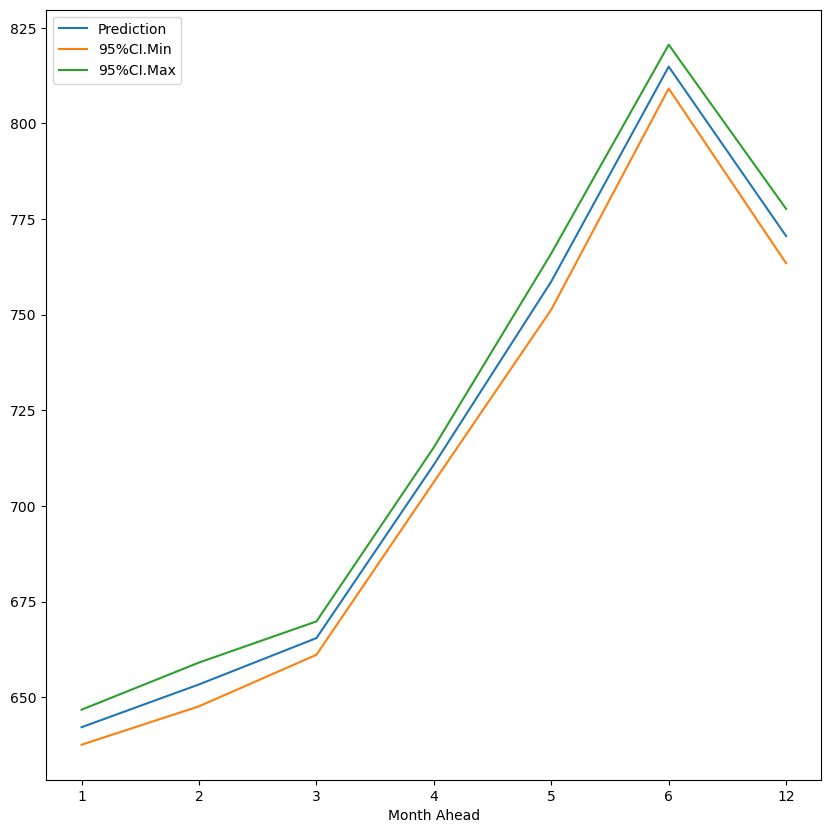

In [10]:
#Concatenate all dataframes by identical columns

df=pd.concat([outcome1, outcome2,outcome3,outcome4,outcome5,outcome6,outcome12])

insert_index = 0
insert_colname = 'Asset'
insert_values = ['Options','Options','Options','Options','Options','Options','Options'] # this can be a numpy array too
df.insert(loc=insert_index, column=insert_colname, value=insert_values)


insert_index = 1
insert_colname = 'Product'
insert_values = ['C2','C2','C2','C2','C2','C2','C2'] # this can be a numpy array too
df.insert(loc=insert_index, column=insert_colname, value=insert_values)

insert_index = 2
insert_colname = 'Month Ahead'
insert_values = ['1','2','3','4','5','6','12'] # this can be a numpy array too
df.insert(loc=insert_index, column=insert_colname, value=insert_values)
df_c2=df

print(df_c2)

import matplotlib.pyplot as mp
df_c2.plot(x='Month Ahead',y=["Prediction","95%CI.Min","95%CI.Max"],kind="line",figsize=(10,10))
mp.show()

## C1 Prediction 1m

In [12]:
#C1 Prediction 1m

#load ensemble
import os
from keras.models import load_model


ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelC1//1//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition//ModelC1//1//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelC1//1//model_corr.h5')

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import io
import datetime

sheet='C1'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))

values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
# print(reframed.shape)


# print(reframed.tail())

# split into train and test sets
values = reframed.values
n_train_months = 26 
#make sure the n_train_months is lower than the number of rows of the array "values" 
#(e.g values.shape is(37, 126)),n_train_months sould be values blow 37

train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = ((n_months+1))* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+5):-n_features*(1+5)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+5):-n_features*(1+5)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1) , n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# prediction interval for mlps on the housing regression dataset
from numpy import asarray
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import math
import numpy as np

 
# define and fit the model
def fit_model(X_train, y_train):
    features = X_train.shape[1]
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, verbose=0, epochs=50, batch_size=16)
    return model

	
 
# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
    ensemble = list()
    for i in range(n_members):
        model = fit_model(X_train, y_train) # define and fit the model on the training set
        yhat = model.predict(X_test, verbose=0) # evaluate model on the test set
        print(y_test.shape,yhat.shape)
        mae = mean_absolute_error(y_test, yhat)
        print('>%d, MAE: %.3f' % (i+1, mae))
        ensemble.append(model) # store the model
    return ensemble

# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X,n_members):
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = asarray(yhat)
    yhat = np.reshape(yhat,[n_members,1])
    print(yhat.shape)
    # yhat = scaled2.inverse_transform(yhat)
    yhat = scaler2.inverse_transform(yhat) # invert scaling for actual
    yhat = yhat[:,0] 
    interval = 1.96 * yhat.std()/math.sqrt(len(yhat))
    lower, upper = yhat.mean() - interval, yhat.mean() + interval
    return lower, yhat.mean(), upper

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }
outcome1= pd.DataFrame(outcome)
outcome1



18
(28, 108)
(2, 108)
(26, 6, 18) (26, 1) (2, 6, 18) (2, 1)


2022-09-04 22:54:18.906775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:54:18.970324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:54:19.320903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:54:19.381346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:54:19.685182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:54:19.742409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:54:20.080703: I tensorflow/core/grappler/optimizers/cust

(25, 1)
95% prediction interval: [2080.2, 2122.0]
True value: 0.6


2022-09-04 22:54:28.312945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:54:28.369881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Prediction,95%CI.Min,95%CI.Max
0,2101.114014,2080.222312,2122.005716


In [ ]:
## C1 Prediction 2m

In [13]:
#C1 Prediction 2m

#load ensemble
# import os
# from keras.models import load_model


ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelC1//2//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition//ModelC1//2//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelC1//2//model_corr.h5')

# from math import sqrt
# from numpy import concatenate
# from matplotlib import pyplot
# import pandas as pd
# from pandas import read_csv
# from pandas import DataFrame
# from pandas import concat
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import mean_squared_error
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM

# from google.colab import drive
# drive.mount('/content/drive')
# import io
# import datetime
sheet='C1'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))

values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
# print(reframed.shape)


# print(reframed.tail())


# split into train and test sets
values = reframed.values
n_train_months = 26
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = ((n_months+1))* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+4):-n_features*(1+4)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+4):-n_features*(1+4)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1) , n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# prediction interval for mlps on the housing regression dataset
from numpy import asarray
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import math
import numpy as np

 
# define and fit the model
def fit_model(X_train, y_train):
    features = X_train.shape[1]
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, verbose=0, epochs=50, batch_size=16)
    return model

	
 
# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
    ensemble = list()
    for i in range(n_members):
        model = fit_model(X_train, y_train) # define and fit the model on the training set
        yhat = model.predict(X_test, verbose=0) # evaluate model on the test set
        print(y_test.shape,yhat.shape)
        mae = mean_absolute_error(y_test, yhat)
        print('>%d, MAE: %.3f' % (i+1, mae))
        ensemble.append(model) # store the model
    return ensemble


# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X,n_members):
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = asarray(yhat)
    yhat = np.reshape(yhat,[n_members,1])
    print(yhat.shape)
    # yhat = scaled2.inverse_transform(yhat)
    yhat = scaler2.inverse_transform(yhat) # invert scaling for actual
    yhat = yhat[:,0] 
    interval = 1.96 * yhat.std()/math.sqrt(len(yhat))
    lower, upper = yhat.mean() - interval, yhat.mean() + interval
    return lower, yhat.mean(), upper

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome2= pd.DataFrame(outcome)
outcome2

18
(28, 108)
    var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  var5(t-5)  var6(t-5)  \
28   0.220145   0.666687   0.727273   0.725592   0.211069   0.588889   
29   0.264174   0.666687   0.818182   0.761185   0.210761   0.677778   
30   1.000000   0.666687   0.909091   1.000000   0.139536   0.744444   
31   0.647768   0.666687   1.000000   0.807662   0.211428   0.766667   
32   0.465621   1.000000   0.000000   0.746077   0.045590   0.822222   

    var7(t-5)  var8(t-5)  var9(t-5)  var10(t-5)  ...   var9(t)  var10(t)  \
28   0.016854   0.741105   0.919374    0.107143  ...  0.967284  0.026786   
29   0.016854   0.819652   1.000000    0.098214  ...  0.960880  0.008929   
30   0.016854   0.828126   0.980065    0.062500  ...  0.947854  0.008929   
31   0.016854   0.848302   0.983663    0.035714  ...  0.946481  0.008929   
32   0.016854   0.863193   0.966805    0.044643  ...  0.958188  0.008929   

    var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  var16(t)  var17(t)  \
28  0.973704  0.39631

2022-09-04 22:55:06.614071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:55:06.675868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:55:07.052047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:55:07.109322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:55:07.452290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:55:07.511771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:55:07.816808: I tensorflow/core/grappler/optimizers/cust

(25, 1)
95% prediction interval: [1937.7, 1978.6]
True value: 0.5


2022-09-04 22:55:15.975322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:55:16.032702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Prediction,95%CI.Min,95%CI.Max
0,1958.16687,1937.701828,1978.631913


In [ ]:
## C1 Prediction 3m

In [15]:
#C1 Prediction 3m

#load ensemble
# import os
# from keras.models import load_model

a=3
ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelC1//3//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition//ModelC1//3//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelC1//3//model_corr.h5')

# from math import sqrt
# from numpy import concatenate
# from matplotlib import pyplot
# import pandas as pd
# from pandas import read_csv
# from pandas import DataFrame
# from pandas import concat
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import mean_squared_error
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM

# from google.colab import drive
# drive.mount('/content/drive')
# import io
# import datetime
sheet='C1'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape

values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)

values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)


n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome3= pd.DataFrame(outcome)
outcome3


2022-09-04 22:57:46.212082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:57:46.271091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:57:46.607946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:57:46.665775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:57:47.002053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:57:47.063443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:57:47.391545: I tensorflow/core/grappler/optimizers/cust

(25, 1)
95% prediction interval: [1844.2, 1868.1]
True value: 0.5


2022-09-04 22:57:56.275208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:57:56.336250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Prediction,95%CI.Min,95%CI.Max
0,1856.164062,1844.179269,1868.148856


## C1 Prediction 4m

In [16]:
#C1 Prediction 4m

#load ensemble
# import os
# from keras.models import load_model

a=4
ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelC1//4//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition//ModelC1//4//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelC1//4//model_corr.h5')

sheet='C1'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))


values=df.values
# #
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
# print(reframed.shape)


# split into train and test sets
values = reframed.values
n_train_months = 26
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = (n_months+1)* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+2):-n_features*(1+2)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+2):-n_features*(1+2)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome4= pd.DataFrame(outcome)
outcome4

18
(28, 108)
(2, 108)
(26, 6, 18) (26, 1) (2, 6, 18) (2, 1)


2022-09-04 22:58:16.190064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:58:16.251582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:58:16.605786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:58:16.663325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:58:17.045656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:58:17.135063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:58:17.519656: I tensorflow/core/grappler/optimizers/cust

(20, 1)
95% prediction interval: [1856.4, 1887.2]
True value: 0.6


2022-09-04 22:58:24.438318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-04 22:58:24.494436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Prediction,95%CI.Min,95%CI.Max
0,1871.802979,1856.447467,1887.15849


In [ ]:
#C1 Prediction 5m

#load ensemble
# import os
# from keras.models import load_model

a=5
ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelC1//5//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition//ModelC1//5//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelC1//5//model_corr.h5')

# from math import sqrt
# from numpy import concatenate
# from matplotlib import pyplot
# import pandas as pd
# from pandas import read_csv
# from pandas import DataFrame
# from pandas import concat
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import mean_squared_error
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM

sheet='C1'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))

values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
# print(reframed.shape)


# print(reframed.tail())

m=6-5
# split into train and test sets
values = reframed.values
n_train_months = 26
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = (n_months+1)* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+m):-n_features*(1+m)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+m):-n_features*(1+m)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome5= pd.DataFrame(outcome)
outcome5

In [ ]:
#C1 Prediction 6m

#load ensemble
# import os
# from keras.models import load_model

a=6
ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelC1//6//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition//ModelC1//6//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelC1//6//model_corr.h5')

sheet='C1'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))



values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # encoder = LabelEncoder()
# # # # print(values[:,0]) #PortQyt Value
# # values[:,0]=encoder.fit_transform(values[:,0])
# # print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
print(reframed.shape)


print(reframed.tail())

m=6-6
# split into train and test sets
values = reframed.values
n_train_months = 26
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = (n_months+1)* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+m):-n_features*(1+m)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+m):-n_features*(1+m)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome6= pd.DataFrame(outcome)
outcome6




In [ ]:
#C1 Prediction 12m

#load ensemble
# import os
# from keras.models import load_model

a=6
ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelC1//12//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition//ModelC1//12//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelC1//12//model_corr.h5')

# from math import sqrt
# from numpy import concatenate
# from matplotlib import pyplot
# import pandas as pd
# from pandas import read_csv
# from pandas import DataFrame
# from pandas import concat
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import mean_squared_error
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM

# from google.colab import drive
# drive.mount('/content/drive')
# import io
# import datetime
sheet='C1'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))


values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # encoder = LabelEncoder()
# # # # print(values[:,0]) #PortQyt Value
# # values[:,0]=encoder.fit_transform(values[:,0])
# # print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
# n_months = 11
n_months = 23
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)

m=6-6
# split into train and test sets
values = reframed.values
n_train_months = 9
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = ((n_months+1)//2)* n_features #the following 12
# n_obs = (n_months+1)* n_features #the following 
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+m):-n_features*(1+m)+1] 
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+m):-n_features*(1+m)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+m):-n_features*(1+m)+1]
print(test.shape)


import matplotlib.pyplot as pp
pp.plot(train_y)
pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1)//2, n_features))
# train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1)//2, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome12= pd.DataFrame(outcome)
outcome12

In [ ]:
#Concatenate all dataframes by identical columns

df=pd.concat([outcome1, outcome2,outcome3,outcome4,outcome5,outcome6,outcome12])

insert_index = 0
insert_colname = 'Asset'
insert_values = ['Options','Options','Options','Options','Options','Options','Options'] # this can be a numpy array too
df.insert(loc=insert_index, column=insert_colname, value=insert_values)


insert_index = 1
insert_colname = 'Product'
insert_values = ['C1','C1','C1','C1','C1','C1','C1'] # this can be a numpy array too
df.insert(loc=insert_index, column=insert_colname, value=insert_values)

insert_index = 2
insert_colname = 'Month Ahead'
insert_values = ['1','2','3','4','5','6','12'] # this can be a numpy array too
df.insert(loc=insert_index, column=insert_colname, value=insert_values)
df_c1=df

print(df_c1)

import matplotlib.pyplot as mp
df_c1.plot(x='Month Ahead',y=["Prediction","95%CI.Min","95%CI.Max"],kind="line",figsize=(10,10))
mp.show()

In [ ]:

import os
from keras.models import load_model

#EXO 1m

ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelEXO//1//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition/ModelEXO//1//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelEXO//1//model_corr.h5')

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


import io
import datetime

sheet='EXO_EDGX Options'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))
# # df=df.drop(['D&J_Close30d_Avg.','D&J_Close30d_Min','Monthly Real GDP Index','TCV','FEDFUNDS','Unemployement Rate','SPX_Price30d_Std.','D&J_Close30d_Std.','VIX_Close30d_Max.','VIX_Close30d_Avg.','VIX_Close30d_Std.','VIX_Close30d_Min.'],axis=1)


values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
# print(reframed.shape)


# print(reframed.tail())

# split into train and test sets
values = reframed.values
n_train_months = 36
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = ((n_months+1))* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+5):-n_features*(1+5)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+5):-n_features*(1+5)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1) , n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# prediction interval for mlps on the housing regression dataset
from numpy import asarray
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import math
import numpy as np

 
# define and fit the model
def fit_model(X_train, y_train):
    features = X_train.shape[1]
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, verbose=0, epochs=100, batch_size=16)
    return model

	
 
# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
    ensemble = list()
    for i in range(n_members):
        model = fit_model(X_train, y_train) # define and fit the model on the training set
        yhat = model.predict(X_test, verbose=0) # evaluate model on the test set
        print(y_test.shape,yhat.shape)
        mae = mean_absolute_error(y_test, yhat)
        print('>%d, MAE: %.3f' % (i+1, mae))
        ensemble.append(model) # store the model
    return ensemble, model

# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X,n_members):
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = asarray(yhat)
    yhat = np.reshape(yhat,[n_members,1])
    print(yhat.shape)
    # yhat = scaled2.inverse_transform(yhat)
    yhat = scaler2.inverse_transform(yhat) # invert scaling for actual
    yhat = yhat[:,0] 
    interval = 1.96 * yhat.std()/math.sqrt(len(yhat))
    lower, upper = yhat.mean() - interval, yhat.mean() + interval
    return lower, yhat.mean(), upper

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }
outcome1= pd.DataFrame(outcome)
outcome1


In [ ]:

import os
from keras.models import load_model

#EXO 2m

ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelEXO//2//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition/ModelEXO//2//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelEXO//2//model_corr.h5')


In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import io
import datetime

sheet='EXO_EDGX Options'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))
# # df=df.drop(['D&J_Close30d_Avg.','D&J_Close30d_Min','Monthly Real GDP Index','TCV','FEDFUNDS','Unemployement Rate','SPX_Price30d_Std.','D&J_Close30d_Std.','VIX_Close30d_Max.','VIX_Close30d_Avg.','VIX_Close30d_Std.','VIX_Close30d_Min.'],axis=1)


values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
print(reframed.shape)


print(reframed.tail())


# split into train and test sets
values = reframed.values
n_train_months = 36
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = ((n_months+1))* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+4):-n_features*(1+4)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+4):-n_features*(1+4)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1) , n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# prediction interval for mlps on the housing regression dataset
from numpy import asarray
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import math
import numpy as np

 
# define and fit the model
def fit_model(X_train, y_train):
    features = X_train.shape[1]
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, verbose=0, epochs=50, batch_size=16)
    return model

	
 
# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
    ensemble = list()
    for i in range(n_members):
        model = fit_model(X_train, y_train) # define and fit the model on the training set
        yhat = model.predict(X_test, verbose=0) # evaluate model on the test set
        print(y_test.shape,yhat.shape)
        mae = mean_absolute_error(y_test, yhat)
        print('>%d, MAE: %.3f' % (i+1, mae))
        ensemble.append(model) # store the model
    return ensemble

    
# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X,n_members):
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = asarray(yhat)
    yhat = np.reshape(yhat,[n_members,1])
    print(yhat.shape)
    # yhat = scaled2.inverse_transform(yhat)
    yhat = scaler2.inverse_transform(yhat) # invert scaling for actual
    yhat = yhat[:,0] 
    interval = 1.96 * yhat.std()/math.sqrt(len(yhat))
    lower, upper = yhat.mean() - interval, yhat.mean() + interval
    return lower, yhat.mean(), upper

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome2= pd.DataFrame(outcome)
outcome2


In [ ]:

import os
from keras.models import load_model

#EXO 3m

ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelEXO//3//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition/ModelEXO//3//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelEXO//3//model_corr.h5')


from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import io
import datetime

sheet='EXO_EDGX Options'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))
# # df=df.drop(['D&J_Close30d_Avg.','D&J_Close30d_Min','Monthly Real GDP Index','TCV','FEDFUNDS','Unemployement Rate','SPX_Price30d_Std.','D&J_Close30d_Std.','VIX_Close30d_Max.','VIX_Close30d_Avg.','VIX_Close30d_Std.','VIX_Close30d_Min.'],axis=1)


values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
# print(reframed.shape)


# print(reframed.tail())


# split into train and test sets
values = reframed.values
n_train_months = 36
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = (n_months+1)* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+3):-n_features*(1+3)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+3):-n_features*(1+3)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



# prediction interval for mlps on the housing regression dataset
from numpy import asarray
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import math
import numpy as np

 
# define and fit the model
def fit_model(X_train, y_train):
    features = X_train.shape[1]
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, verbose=0, epochs=100, batch_size=16)
    return model

	
 
# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
    ensemble = list()
    for i in range(n_members):
        model = fit_model(X_train, y_train) # define and fit the model on the training set
        yhat = model.predict(X_test, verbose=0) # evaluate model on the test set
        print(y_test.shape,yhat.shape)
        mae = mean_absolute_error(y_test, yhat)
        print('>%d, MAE: %.3f' % (i+1, mae))
        ensemble.append(model) # store the model
    return ensemble

# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X,n_members):
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = asarray(yhat)
    yhat = np.reshape(yhat,[n_members,1])
    print(yhat.shape)
    # yhat = scaled2.inverse_transform(yhat)
    yhat = scaler2.inverse_transform(yhat) # invert scaling for actual
    yhat = yhat[:,0] 
    interval = 1.96 * yhat.std()/math.sqrt(len(yhat))
    lower, upper = yhat.mean() - interval, yhat.mean() + interval
    return lower, yhat.mean(), upper

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome3= pd.DataFrame(outcome)
outcome3


In [ ]:
import os
from keras.models import load_model

#EXO 4m

ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelEXO//4//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition/ModelEXO//4//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelEXO//4//model_corr.h5')

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import io
import datetime

sheet='EXO_EDGX Options'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))
# # df=df.drop(['D&J_Close30d_Avg.','D&J_Close30d_Min','Monthly Real GDP Index','TCV','FEDFUNDS','Unemployement Rate','SPX_Price30d_Std.','D&J_Close30d_Std.','VIX_Close30d_Max.','VIX_Close30d_Avg.','VIX_Close30d_Std.','VIX_Close30d_Min.'],axis=1)


values=df.values
# #
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
# print(reframed.shape)


# print(reframed.tail())


# split into train and test sets
values = reframed.values
n_train_months = 36
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = (n_months+1)* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+2):-n_features*(1+2)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+2):-n_features*(1+2)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# prediction interval for mlps on the housing regression dataset
from numpy import asarray
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import math
import numpy as np

# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
    ensemble = list()
    for i in range(n_members):
        model = fit_model(X_train, y_train) # define and fit the model on the training set
        yhat = model.predict(X_test, verbose=0) # evaluate model on the test set
        print(y_test.shape,yhat.shape)
        mae = mean_absolute_error(y_test, yhat)
        print('>%d, MAE: %.3f' % (i+1, mae))
        ensemble.append(model) # store the model
    return ensemble

# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X,n_members):
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = asarray(yhat)
    yhat = np.reshape(yhat,[n_members,1])
    print(yhat.shape)
    # yhat = scaled2.inverse_transform(yhat)
    yhat = scaler2.inverse_transform(yhat) # invert scaling for actual
    yhat = yhat[:,0] 
    interval = 1.96 * yhat.std()/math.sqrt(len(yhat))
    lower, upper = yhat.mean() - interval, yhat.mean() + interval
    return lower, yhat.mean(), upper

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome4= pd.DataFrame(outcome)
outcome4

In [ ]:
import os
from keras.models import load_model

#EXO 5m

ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelEXO//5//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition/ModelEXO//5//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelEXO//5//model_corr.h5')

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import io
import datetime

sheet='EXO_EDGX Options'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))
# # df=df.drop(['D&J_Close30d_Avg.','D&J_Close30d_Min','Monthly Real GDP Index','TCV','FEDFUNDS','Unemployement Rate','SPX_Price30d_Std.','D&J_Close30d_Std.','VIX_Close30d_Max.','VIX_Close30d_Avg.','VIX_Close30d_Std.','VIX_Close30d_Min.'],axis=1)

m=6-5
# split into train and test sets
values = reframed.values
n_train_months = 36
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = (n_months+1)* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+m):-n_features*(1+m)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+m):-n_features*(1+m)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# prediction interval for mlps on the housing regression dataset
from numpy import asarray
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import math
import numpy as np

 
# define and fit the model
def fit_model(X_train, y_train):
    features = X_train.shape[1]
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, verbose=0, epochs=50, batch_size=16)
    return model

	
 
# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
    ensemble = list()
    for i in range(n_members):
        model = fit_model(X_train, y_train) # define and fit the model on the training set
        yhat = model.predict(X_test, verbose=0) # evaluate model on the test set
        print(y_test.shape,yhat.shape)
        mae = mean_absolute_error(y_test, yhat)
        print('>%d, MAE: %.3f' % (i+1, mae))
        ensemble.append(model) # store the model
    return ensemble


    
# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X,n_members):
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = asarray(yhat)
    yhat = np.reshape(yhat,[n_members,1])
    print(yhat.shape)
    # yhat = scaled2.inverse_transform(yhat)
    yhat = scaler2.inverse_transform(yhat) # invert scaling for actual
    yhat = yhat[:,0] 
    interval = 1.96 * yhat.std()/math.sqrt(len(yhat))
    lower, upper = yhat.mean() - interval, yhat.mean() + interval
    return lower, yhat.mean(), upper

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome5= pd.DataFrame(outcome)
outcome5

In [ ]:
import os
from keras.models import load_model

#EXO 6m

ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelEXO//6//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition/ModelEXO//6//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelEXO//6//model_corr.h5')

sheet='EXO_EDGX Options'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

values=df.values

values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)

m=6-6
# split into train and test sets
values = reframed.values
n_train_months = 36
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = (n_months+1)* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+m):-n_features*(1+m)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+m):-n_features*(1+m)+1]
print(test.shape)

train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome6= pd.DataFrame(outcome)
outcome6

In [ ]:
import os
from keras.models import load_model

#EXO 12m

ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelEXO//12//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition/ModelEXO//12//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelEXO//12//model_corr.h5')


sheet='EXO_EDGX Options'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

values=df.values

values = values.astype('float32')

# specify the number of lag hours
# n_months = 11
n_months = 23
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)

m=6-6
# split into train and test sets
values = reframed.values
n_train_months = 17
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = ((n_months+1)//2)* n_features #the following 12
# n_obs = (n_months+1)* n_features #the following 
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+m):-n_features*(1+m)+1] 
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+m):-n_features*(1+m)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+m):-n_features*(1+m)+1]
print(test.shape)

train_X = train_X.reshape((train_X.shape[0], (n_months+1)//2, n_features))
# train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1)//2, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome12= pd.DataFrame(outcome)
outcome12

In [ ]:
#Concatenate all dataframes by identical columns

df=pd.concat([outcome1, outcome2,outcome3,outcome4,outcome5,outcome6,outcome12])

insert_index = 0
insert_colname = 'Asset'
insert_values = ['Options','Options','Options','Options','Options','Options','Options'] # this can be a numpy array too
df.insert(loc=insert_index, column=insert_colname, value=insert_values)


insert_index = 1
insert_colname = 'Product'
insert_values = ['EXO','EXO','EXO','EXO','EXO','EXO','EXO'] # this can be a numpy array too
df.insert(loc=insert_index, column=insert_colname, value=insert_values)

insert_index = 2
insert_colname = 'Month Ahead'
insert_values = ['1','2','3','4','5','6','12'] # this can be a numpy array too
df.insert(loc=insert_index, column=insert_colname, value=insert_values)
df_exo=df

print(df_exo)

import matplotlib.pyplot as mp
df_exo.plot(x='Month Ahead',y=["Prediction","95%CI.Min","95%CI.Max"],kind="line",figsize=(10,10))
mp.show()

In [ ]:
#BZX_1m

ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelBZX//1//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition/ModelBZX//1//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelBZX//1//model_corr.h5')

sheet='OPT_BZX BATS'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))


values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)


# split into train and test sets
values = reframed.values
n_train_months = 36
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = ((n_months+1))* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+5):-n_features*(1+5)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+5):-n_features*(1+5)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1) , n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }
outcome1= pd.DataFrame(outcome)
outcome1

In [ ]:
#BZX_2m

import os
from keras.models import load_model

ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelBZX//2//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition/ModelBZX//2//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelBZX//2//model_corr.h5')

sheet='BZX'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))

values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
print(reframed.shape)


print(reframed.tail())


# split into train and test sets
values = reframed.values
n_train_months = 36
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = ((n_months+1))* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+4):-n_features*(1+4)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+4):-n_features*(1+4)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1) , n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome2= pd.DataFrame(outcome)
outcome2




In [ ]:
#BZX_3m

import os
from keras.models import load_model

ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelBZX//3//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition/ModelBZX//3//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelBZX//3//model_corr.h5')

sheet='BZX'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))


values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)

# split into train and test sets
values = reframed.values
n_train_months = 36
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = (n_months+1)* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+3):-n_features*(1+3)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+3):-n_features*(1+3)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome3= pd.DataFrame(outcome)
outcome3




In [ ]:
#BZX_4m

import os
from keras.models import load_model

ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelBZX//4//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition/ModelBZX//4//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelBZX//4//model_corr.h5')

sheet='BZX'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))


values=df.values
# #
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)

# split into train and test sets
values = reframed.values
n_train_months = 36
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = (n_months+1)* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+2):-n_features*(1+2)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+2):-n_features*(1+2)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome4= pd.DataFrame(outcome)
outcome4

In [ ]:
#BZX_5m

import os
from keras.models import load_model

ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelBZX//5//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition/ModelBZX//5//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelBZX//5//model_corr.h5')

sheet='BZX'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))


values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)


m=6-5
# split into train and test sets
values = reframed.values
n_train_months = 36
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = (n_months+1)* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+m):-n_features*(1+m)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+m):-n_features*(1+m)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome5= pd.DataFrame(outcome)
outcome5

In [ ]:
#BZX_6m

import os
from keras.models import load_model

ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelBZX//6//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition/ModelBZX//6//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelBZX//6//model_corr.h5')

sheet='BZX'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))


values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # encoder = LabelEncoder()
# # # # print(values[:,0]) #PortQyt Value
# # values[:,0]=encoder.fit_transform(values[:,0])
# # print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)



m=6-6
# split into train and test sets
values = reframed.values
n_train_months = 26
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = (n_months+1)* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+m):-n_features*(1+m)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+m):-n_features*(1+m)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome6= pd.DataFrame(outcome)
outcome6


In [ ]:
#BZX_12m

import os
from keras.models import load_model

ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelBZX//12//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition/ModelBZX//12//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelBZX//12//model_corr.h5')


sheet='CFE'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))

values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # encoder = LabelEncoder()
# # # # print(values[:,0]) #PortQyt Value
# # values[:,0]=encoder.fit_transform(values[:,0])
# # print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
# n_months = 11
n_months = 23
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)

m=6-6
# split into train and test sets
values = reframed.values
n_train_months = 17
train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = ((n_months+1)//2)* n_features #the following 12
# n_obs = (n_months+1)* n_features #the following 
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+m):-n_features*(1+m)+1] 
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+m):-n_features*(1+m)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+m):-n_features*(1+m)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1)//2, n_features))
# train_X = train_X.reshape((train_X.shape[0], (n_months+1), n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1)//2, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }


outcome12= pd.DataFrame(outcome)
outcome12


In [ ]:
#Concatenate all dataframes by identical columns



df=pd.concat([outcome1, outcome2,outcome3,outcome4,outcome5,outcome6,outcome12])



insert_index = 0
insert_colname = 'Asset'
insert_values = ['Options','Options','Options','Options','Options','Options','Options'] # this can be a numpy array too
df.insert(loc=insert_index, column=insert_colname, value=insert_values)




insert_index = 1
insert_colname = 'Product'
insert_values = ['BZX','BZX','BZX','BZX','BZX','BZX','BZX'] # this can be a numpy array too
df.insert(loc=insert_index, column=insert_colname, value=insert_values)



insert_index = 2
insert_colname = 'Month Ahead'
insert_values = ['1','2','3','4','5','6','12'] # this can be a numpy array too
df.insert(loc=insert_index, column=insert_colname, value=insert_values)
df_BZX=df



print(df_BZX)



# import matplotlib.pyplot as mp
# df_c1.plot(x='Month Ahead',y=["Prediction","95%CI.Min","95%CI.Max"],kind="line",figsize=(10,10))
# mp.show()

In [ ]:
#BYX_12m

import os
from keras.models import load_model

ensemble=[]
i=0
while os.path.exists(f'Train & Predicition//ModelBYX//12//ensemble_corr_{i}.h5'):
  ensemble.append(load_model(f'Train & Predicition/ModelBYX//12//ensemble_corr_{i}.h5'))
  i+=1
#load model
model=load_model('Train & Predicition//ModelBYX//12//model_corr.h5')

sheet='BYX'
df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name=sheet,header=0)
# df= pd.read_excel(r'Logical Ports Prediction.xlsx',sheet_name='C2',header=0)
df.dropna(subset=['Date'],inplace=True)

from datetime import datetime as dt
last_date=df.loc[:,'Date']
last_date=last_date.iat[-1]
last_date=last_date.strftime('%Y-%m-%d')
last_date

df=df[df['Date']<=last_date].reset_index(drop=True)
df.tail()
df['Year'] = pd.to_datetime(df['Date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')

df.drop(['Date','Logical Ports','Asset'],axis=1,inplace=True)
first_column = df.pop('Year')
df.insert(0, 'Year', first_column)
second_column = df.pop('Month')
df.insert(1, 'Month', second_column)
first_column = df.pop('PortQyt')
df.insert(0, 'PortQyt', first_column)

df.shape
print(len(list(df)[:]))


values=df.values
#
# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# encoder = LabelEncoder()
# # # print(values[:,0]) #PortQyt Value
# values[:,0]=encoder.fit_transform(values[:,0])
# print(values[:,0])

# import matplotlib.pyplot as pp
# pp.plot(values[:,0])
# pp.show()

# # print(values[:,4].shape)
# # print(values[:,4])
values = values.astype('float32')

# specify the number of lag hours
n_months = 5
n_features = len(list(df)[:])

#Normalize the first feature
from sklearn.preprocessing import StandardScaler
scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(values[:,0:1])
# train_y = scaler2.transform(values[:,-n_features])
# scaled2 = scaler2.fit_transform(values) #try


# # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# len(list(dataset.columns))-3

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
# print(reframed.shape)


# print(reframed.tail())


# split into train and test sets
values = reframed.values
n_train_months = 36 
#make sure the n_train_months is lower than the number of rows of the array "values" 
#(e.g values.shape is(37, 126)),n_train_months sould be values blow 37

train = values[:n_train_months, :]
test = values[n_train_months:, :]
print(values.shape)
# split into input and outputs
n_obs = ((n_months+1))* n_features #the following fourth month
train.shape
train_X, train_y = train[:, :n_obs], train[:, -n_features*(1+5):-n_features*(1+5)+1] 
test_X, test_y = test[:, :n_obs], test[:, -n_features*(1+5):-n_features*(1+5)+1]
print(test.shape)


# import matplotlib.pyplot as pp
# pp.plot(train_y)
# pp.show()

train_X = train_X.reshape((train_X.shape[0], (n_months+1) , n_features))
test_X = test_X.reshape((test_X.shape[0], (n_months+1), n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

n_members=len(ensemble)
# make predictions with prediction interval
newX = asarray([test_X[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX,n_members)
# print(test_y)
# print('Point prediction: %.1f' % mean)
print('95%% prediction interval: [%.1f, %.1f]' % (lower, upper))
print('True value: %.1f' % test_y[0])
outcome = {'Prediction': [mean],
           '95%CI.Min': [lower],
           '95%CI.Max': [upper]
           }
outcome1= pd.DataFrame(outcome)
outcome1

In [ ]:
#BYX_2M

In [ ]:
#BYX_2M